In [97]:
#importeren van de libraries die we gebruiken bij de dataverkenning
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [98]:
'''Op het moment van schrijven is er nog geen nieuwe rest-server versie van de data, dus gebruik ik hier de csv
van de nieuwe data. Zodra de data op te halen is vanaf de server zal ik dit in deze notebook zetten'''

'Op het moment van schrijven is er nog geen nieuwe rest-server versie van de data, dus gebruik ik hier de csv\nvan de nieuwe data. Zodra de data op te halen is vanaf de server zal ik dit in deze notebook zetten'

In [99]:
#dataframe maken van csv
df = pd.read_csv('data_new.csv')

In [100]:
#eerste blik werpen op ons df
df.head()

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
0,73.9,185,99.7,0.9,0.0,2.4,6.9,73.1
1,86.0,172,105.4,1.8,8.1,0.4,4.2,85.0
2,83.3,176,111.4,1.1,0.8,4.6,7.5,81.6
3,82.8,164,111.4,4.7,11.8,1.0,2.9,81.0
4,78.7,178,71.6,1.5,8.3,4.9,5.5,75.0


In [101]:
#kijken hoeveel rijen we hebben
df.shape

(4096, 8)

In [102]:
'''We hebben dus een dataframe met 4096 rijen (waarbinnen elke rij de data van één persoon bevat). 
Daarnaast hebben we voor elke rij/persoon 8 variabelen.'''

'We hebben dus een dataframe met 4096 rijen (waarbinnen elke rij de data van één persoon bevat). \nDaarnaast hebben we voor elke rij/persoon 8 variabelen.'

In [103]:
#we bekijken wat voor soort data we hebben in elke kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4096 non-null   object 
 1   length    4096 non-null   object 
 2   mass      4096 non-null   object 
 3   exercise  4096 non-null   object 
 4   smoking   4096 non-null   float64
 5   alcohol   4096 non-null   object 
 6   sugar     4096 non-null   object 
 7   lifespan  4096 non-null   float64
dtypes: float64(2), object(6)
memory usage: 256.1+ KB


In [104]:
#hier lopen we tegen een eerste probleem aan. Alleen lifespan en smoking zijn floats, de rest van de variabelen
#zijn van het type 'object', en worden hierdoor kennelijk niet meegenomen door .describe()
df.describe()

#df.astype(float) werkt niet, want dit geeft aan dat er '?' waardes in het df zitten

,smoking,lifespan
count,4096.000000,4096.000000
mean,9.807446,80.127783
std,6.921461,8.042270
min,0.000000,-1.000000
25%,3.300000,75.000000
50%,9.500000,79.700000
75%,15.900000,85.200000
max,22.200000,105.100000


In [105]:
#Het lijkt erop dat er een aantal waardes in het df dus '?' bevatten. We bekijken hoeveel dit er zijn:

print(df.isin(['?']).sum(axis=0))

genetic     1
length      0
mass        2
exercise    1
smoking     0
alcohol     2
sugar       1
lifespan    0
dtype: int64


In [106]:
#We verwijderen de rijen met een '?' waarde:

for c in df.columns:
    df.drop(df.index[df[c] == '?'], inplace = True)

#Nogmaals checken of ze er uit zijn:

print(df.isin(['?']).sum(axis=0))

genetic     0
length      0
mass        0
exercise    0
smoking     0
alcohol     0
sugar       0
lifespan    0
dtype: int64


In [107]:
#We kunnen specifieker bekijken wat er voor type data er in elke kolom staat:

for c in df.columns:
    print(pd.api.types.infer_dtype(df[c]))

string
string
string
string
floating
string
string
floating


In [108]:
# We hebben dus een aantal columns die van het type string zijn. 

# We veranderen nu alle columns naar het datatype float:
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [109]:
#Wat we ook nog moeten bekijken is of er cellen zijn met als waarde '0' terwijl dit niet zou kunnen,
#zoals bij lengte, massa of lifespan
print(df.isin([0]).sum(axis=0))

genetic      0
length       0
mass         0
exercise     0
smoking     53
alcohol     12
sugar        0
lifespan     0
dtype: int64


In [110]:
#Nu hebben we een dataframe zonder lege cellen en met enkel floats als datatypes
df.describe()

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
count,4089.000000,4086.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000,4089.000000
mean,82.274762,183.879344,92.277085,2.403057,9.808853,2.265909,6.485424,80.133749
std,7.441850,12.627470,25.795830,1.170342,6.918644,1.800475,2.710271,8.041613
min,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,0.700000,-1.000000
25%,77.600000,175.000000,71.500000,1.500000,3.400000,0.600000,4.400000,75.000000
50%,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,6.300000,79.700000
75%,86.700000,193.000000,110.900000,3.200000,15.900000,4.000000,8.400000,85.200000
max,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,13.800000,105.100000


In [111]:
# We zien nog wel dat er bijvoorbeeld vreemde waardes in het df staan; zo is de minimale waarde
# van 'lifespan' -1, en dat klopt natuurlijk niet. Dit brengt ons bij het detecteren van eventuele outliers:

<AxesSubplot: xlabel='lifespan'>

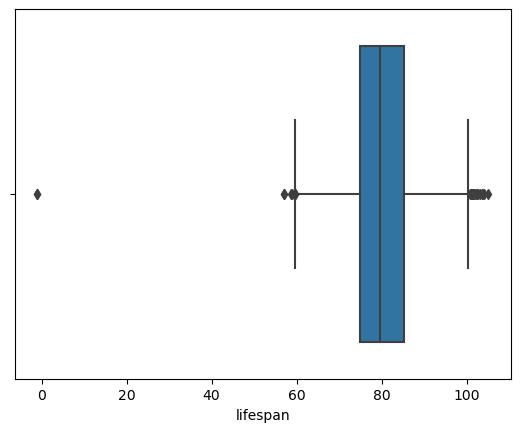

In [112]:
sns.boxplot(x=df['lifespan'])

In [113]:
#Dit is overduidelijk een fout datapunt, aangezien het niet mogelijk is om een lifespan van -1 te hebben. 
#We kijken of er nog meer rijen zijn waarin dit zo is (dit is niet goed te zien op de boxplot):

df.loc[df['lifespan'] < 0]

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
889,88.1,156.0,112.9,0.7,19.5,0.9,3.0,-1.0
2300,82.6,188.0,63.1,3.6,15.0,0.2,1.0,-1.0


In [114]:
#We zien dat het om twee rijen gaat. Deze verwijderen we uit het dataframe:

df.drop(df.loc[df['lifespan'] < 0].index, inplace=True)

In [115]:
df.loc[df['lifespan'] < 0] # geeft nu geen rijen meer terug, dat is mooi.

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan


<AxesSubplot: >

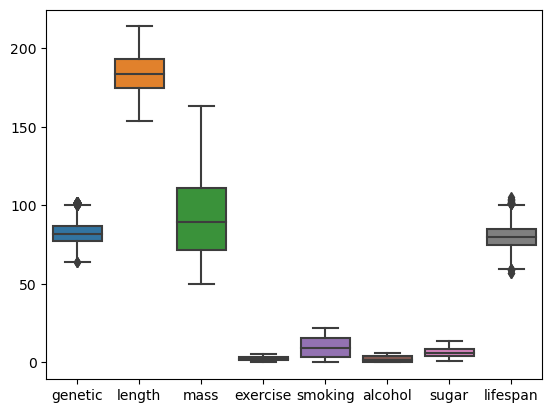

In [116]:
# We kunnen nog voor alle andere variabelen boxplots maken, hoewel de assen dan niet goed zijn geschaald:
sns.boxplot(df)

In [ ]:
#Er lijken alleen nog wat outliers te zitten in 'genetic' en 'lifespan', maar aangezien dit geen onmogelijke waardes
#zijn, en ons model in het geval van de "juiste" input ook moet kunnen voorspellen dat iemand 100+ wordt, halen
#we deze er niet uit. Met een max waarde van 105.1 is het ook geen uitzonderlijk hoge waarde. 

In [93]:
#Nu kunnen we een BMI variabel toevoegen aan ons dataframe - zo kunnen we kijken of deze gecombineerde waarde meer 
#zegt/voorspellen waarde heeft dan lengte en massa apart:

df['BMI'] = df['mass'] / ((df['length'])/100)**2

In [94]:
df['BMI'].describe()

count    4084.000000
mean       27.682015
std         8.711661
min        11.320500
25%        20.938542
50%        26.476726
75%        33.207260
max        65.869494
Name: BMI, dtype: float64

<AxesSubplot: xlabel='BMI'>

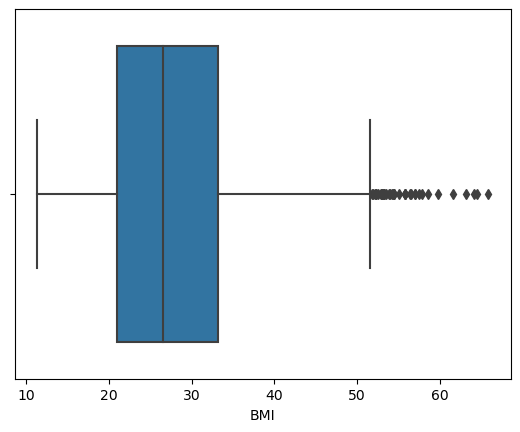

In [95]:
sns.boxplot(x=df['BMI'])

<AxesSubplot: >

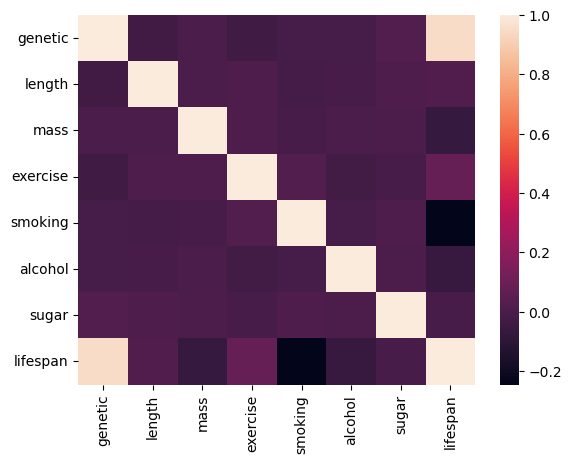

In [119]:
sns.heatmap(df.corr())